In [1]:
import json
import gzip
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.lines import Line2D

In [3]:
path_study_results = Path("/Users/lisepauwels/sps_simulations/Studies/MomentumAcceptance/IntensityScan/study_results")
name_files = [p.name for p in path_study_results.iterdir()]

In [4]:
def df_to_delta(df):
    slip_factor = 0.0017935055033301713
    f = 200_000_000
    return 1/slip_factor * df/f

In [5]:
sweep_per_turn = 1.0
data = {'linear' : {}, 'errors': {}}
for name_file in name_files:
    with gzip.open(path_study_results / name_file, "rt") as f:
        study_results = json.load(f)

    line_type = name_file.split("_")[1]
    chroma = float(name_file.split("_")[2].split(".json")[0])
    print(line_type, chroma)
    if chroma not in data[line_type]:
        data[line_type][chroma] = {}
    
    for plane in list(study_results.keys()):
        assert abs(study_results[plane]['sweep_per_turn']) == sweep_per_turn
        turns, counts = np.unique(study_results[plane]['at_turn'], return_counts=True)
        data[line_type][chroma][plane] = {'turns' : turns, 'counts' : counts}


errors 0.7
linear 0.5
linear 1.0
errors 0.5
linear 0.7
errors 1.0


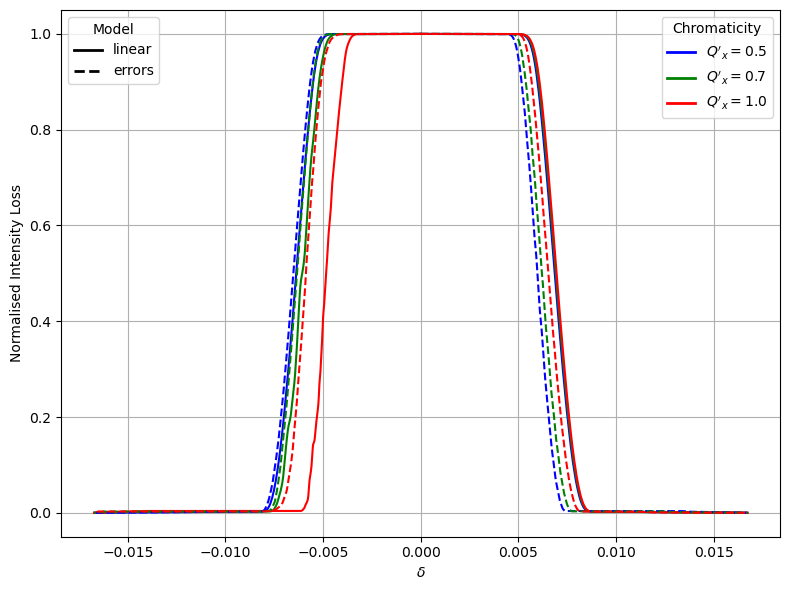

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
num_particles = 2000*500
colors = {0.5 : 'blue', 0.7 : 'green', 1.0 : 'red'}
line_styles = {'linear' : '-', 'errors' : '--'}

for line_type in ['linear', 'errors']:
    for chroma in sorted(data[line_type].keys()):
        for plane in ['DPpos', 'DPneg']:
            turns=data[line_type][chroma][plane]['turns']
            counts=data[line_type][chroma][plane]['counts']
            turns = np.concatenate(([0], turns))
            counts =  np.concatenate(([0], counts))
            deltas = df_to_delta(turns * sweep_per_turn)
            if plane == 'DPneg':
                deltas = -deltas
            ax.plot(deltas, 1-np.cumsum(counts)/num_particles, color=colors[chroma], linestyle=line_styles[line_type])

#Legend
chroma_handles = [
    Line2D(
        [0], [0],
        color=colors[chroma],
        linestyle='-',
        linewidth=2,
        label=rf"$Q'_x = {chroma}$"
    )
    for chroma in sorted(colors)
]

legend_chroma = ax.legend(
    handles=chroma_handles,
    title="Chromaticity",
    loc="upper right",
    frameon=True,
)

ax.add_artist(legend_chroma)

line_handles = [
    Line2D(
        [0], [0],
        color='black',
        linestyle=line_styles[line_type],
        linewidth=2,
        label=line_type
    )
    for line_type in line_styles
]

ax.legend(
    handles=line_handles,
    title="Model",
    loc="upper left",
    frameon=True,
)
ax.grid()
ax.set_xlabel(r'$\delta$')
ax.set_ylabel('Normalised Intensity Loss')
fig.tight_layout()
plt.savefig('IntensityScan_results.png', dpi=300)